In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import csv
import numpy as np
%matplotlib inline 
from matplotlib.ticker import MultipleLocator
from sklearn.preprocessing import normalize
import pandas as pd
from sklearn.decomposition import PCA
import umap
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report

import os 
from keras.layers import Conv1D, MaxPooling1D, SpatialDropout1D
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from keras.utils.vis_utils import plot_model
from keras import initializers
from keras import regularizers
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import * # Keras is the most friendly Neural Network library, this Kernel use a lot of layers classes
from keras.models import Model
from tqdm import tqdm # Processing time measurement
from sklearn.model_selection import train_test_split 
from keras import backend as K # The backend give us access to tensorflow operations and allow us to create the Attention class
from keras import optimizers # Allow us to access the Adam class to modify some parameters
from sklearn.model_selection import GridSearchCV, StratifiedKFold # Used to use Kfold to train our model
from keras.callbacks import * # This object helps the model to train in a smarter way, avoiding overfitting

Using TensorFlow backend.
/home/julie/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/julie/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/julie/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/julie/anaconda3/lib/python3.7/site-packages/tensorflo

In [2]:
train = pd.read_csv("data/7C_train.csv", sep="\t")
valid = pd.read_csv("data/7C_valid.csv", sep="\t")

y_train = train["Compartment Prediction"]
y_valid = valid["Compartment Prediction"]

x_train = train["Sequence"].copy()
x_valid = valid["Sequence"].copy()

In [3]:
print(len(x_train), 'train sequences')
print(len(x_valid), 'valid sequences')

3229 train sequences
710 valid sequences


In [4]:
train.head(10)

,Lead Protein ID,Compartment Prediction,Prediction Confidence,Sequence,Sequence Lengh,ExpAA,First60,PredHel,Topology,Topology Seq,Prediction,SP(Sec/SPI),CS Position,Signal Peptide Seq
0,Q9GZS1,Large Protein Complex,High,MAAEVLPSARWQYCGAPDGSQRAVLVQFSNGKLQSPGNMRFTLYEN...,419,0.15,0.00,0,[],0000000000000000000000000000000000000000000000...,OTHER,0.000870,[],0000000000000000000000000000000000000000000000...
1,Q9BV79,Mitochondrion,Low,MWVCSTLWRVRTPARQWRGLLPASGCHGPAASSYSASAEPARVRAL...,373,0.32,0.01,0,[],0000000000000000000000000000000000000000000000...,OTHER,0.006977,[],0000000000000000000000000000000000000000000000...
2,P30153,Large Protein Complex,Very High,MAAADGDDSLYPIAVLIDELRNEDVQLRLNSIKKLSTIALALGVER...,589,0.01,0.00,0,[],0000000000000000000000000000000000000000000000...,OTHER,0.000542,[],0000000000000000000000000000000000000000000000...
3,P62308,Large Protein Complex,Very High,MSKAHPPELKKFMDKKLSLKLNGGRHVQGILRGFDPFMNLVIDECV...,76,0.01,0.00,0,[],0000000000000000000000000000000000000000000000...,OTHER,0.000583,[],0000000000000000000000000000000000000000000000...
4,Q92888,Large Protein Complex,Very High,MEDFARGAASPGPSRPGLVPVSIIGAEDEDFENELETNSEEQNSQF...,912,0.00,0.00,0,[],0000000000000000000000000000000000000000000000...,OTHER,0.000912,[],0000000000000000000000000000000000000000000000...
5,P31946,Large Protein Complex,Very High,MTMDKSELVQKAKLAEQAERYDDMAAAMKAVTEQGHELSNEERNLL...,246,0.04,0.00,0,[],0000000000000000000000000000000000000000000000...,OTHER,0.000383,[],0000000000000000000000000000000000000000000000...
6,O75882,ER,Very Low,MVAAAAATEARLRRRTAATAALAGRSGGPHWDWDVTRAGRPGLGAG...,1429,26.26,0.05,1,['1279-1301'],0000000000000000000000000000000000000000000000...,OTHER,0.089563,[],0000000000000000000000000000000000000000000000...
7,P53004,Large Protein Complex,High,MNAEPERKFGVVVVGVGRAGSVRMRDLRNPHPSSAFLNLIGFVSRR...,296,0.35,0.00,0,[],0000000000000000000000000000000000000000000000...,OTHER,0.000697,[],0000000000000000000000000000000000000000000000...
8,P78330,Large Protein Complex,Very Low,MVSHSELRKLFYSADAVCFDVDSTVIREEGIDELAKICGVEDAVSE...,225,0.01,0.00,0,[],0000000000000000000000000000000000000000000000...,OTHER,0.001496,[],0000000000000000000000000000000000000000000000...
9,P35611,Large Protein Complex,High,MNGDSRAAVVTSPPPTTAPHKERYFDRVDENNPEYLRERNMAPDLR...,737,0.06,0.00,0,[],0000000000000000000000000000000000000000000000...,OTHER,0.000577,[],0000000000000000000000000000000000000000000000...


In [5]:
train_helix = train["Topology Seq"]
valid_helix = valid["Topology Seq"]

train_signalP = train["Signal Peptide Seq"]
valid_signalP = valid["Signal Peptide Seq"]

In [6]:
max_len = 1500
# all amino acids (in blosum order)
aa = "*ARNDCQEGHILKMFPSTWYVU"
tot_aa = len(aa)

# define a mapping of aa to integers
aa_to_int = dict((c, i) for i, c in enumerate(aa))
int_to_aa = dict((i, c) for i, c in enumerate(aa))

## One hot encoding of Labels

In [7]:
# NB: DO NOT USE SET, IT CHANGES ORDER OF CATEGORY EVERYTIME I RUN THE NOTEBOOK!!!!
#cat = list(set(y_train))
cat = ['ER',
 'Golgi',
 'Mitochondrion',
 'Endosome',
 'Large Protein Complex',
 'Plasma membrane',
 'Lysosome']

In [8]:
tot_cat = len(cat)
cat_to_int = {}
int_to_cat = {}
for i in range(tot_cat):
    cat_to_int[cat[i]] = i
    int_to_cat[i] = cat[i]   

In [9]:
def cat_to_indices(Y):
    Y_indices = np.zeros([Y.shape[0],], dtype=int)
    for i in range(len(Y)):
        Y_indices[i] = cat_to_int[Y[i]]
    return Y_indices

# one hot encode
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [10]:
y_train_indices = cat_to_indices(y_train)
y_valid_indices = cat_to_indices(y_valid)

y_train_OH = convert_to_one_hot(y_train_indices, C = tot_cat)
y_valid_OH = convert_to_one_hot(y_valid_indices, C = tot_cat)

## X_train processing: 
### From Sequences to list of indices

In [11]:
# Function to convert sequences to array of indices. I will use that one for embedding 

def seq_to_indices(X, aa_to_int, max_len):
    
    m = X.shape[0]                                   # number of training examples
    
    ### START CODE HERE ###
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = []
    
    for i in range(m):                               # loop over training examples
        seq_aa = X[i]
        seq_ind = []
        
        # Loop over the words of sentence_words
        for w in range(len(seq_aa)):
            seq_ind.append(aa_to_int[seq_aa[w]])
            
        X_indices.append(seq_ind)
            
    ### END CODE HERE ###
    
    return X_indices

In [12]:
x_train_indices = seq_to_indices(x_train, aa_to_int, max_len)
x_valid_indices = seq_to_indices(x_valid, aa_to_int, max_len)

In [13]:
def convert_to_list(column):
    new = []
    for seq in column:
        new.append(list(map(int, seq)))
    return new

In [14]:
train_helix = convert_to_list(train_helix)
valid_helix = convert_to_list(valid_helix)

train_signalP = convert_to_list(train_signalP)
valid_signalP = convert_to_list(valid_signalP)

In [15]:
# Pad sequences
# By default, the padding is added before the sequence
x_train_pad = sequence.pad_sequences(x_train_indices, maxlen=max_len, value=aa_to_int["*"])
x_valid_pad = sequence.pad_sequences(x_valid_indices, maxlen=max_len, value=aa_to_int["*"])
print('x_train shape:', x_train_pad.shape)
print('x_valid shape:', x_valid_pad.shape)

x_train shape: (3229, 1500)
x_valid shape: (710, 1500)


In [16]:
train_helix_pad = sequence.pad_sequences(train_helix, maxlen=max_len, value=0)
valid_helix_pad = sequence.pad_sequences(valid_helix, maxlen=max_len, value=0)

train_signalP_pad = sequence.pad_sequences(train_signalP, maxlen=max_len, value=0)
valid_signalP_pad = sequence.pad_sequences(valid_signalP, maxlen=max_len, value=0)

In [17]:
# One hot to label 
#Y is list of OH vector
def OH_to_label_indices(Y):
    labels = []
    for a in Y:
        indices = np.argmax(a)
        labels.append(indices)
    return labels

In [18]:
def indices_to_cat(Y):
    Y_cat = []
    for i in range(len(Y)):
        Y_cat.append(int_to_cat[Y[i]])
    return Y_cat

## Model 1

In [89]:
max_features = tot_aa
batch_size = 32

#LSTM
units = 128
# Embedding
embedding_size = 40
feature_embedding_size = 2
# Convolution
filters = 20
pool_size = 2

input_seq = Input(shape=[max_len], dtype='int32')
input_helix = Input(shape=[max_len], dtype='int32')
input_signalP = Input(shape=[max_len], dtype='int32')

# get the embedding layer
embedded_seq = Embedding(input_dim=max_features,output_dim=embedding_size,
        input_length=max_len, name = 'embedding_seq', trainable=True, mask_zero=False)(input_seq)

embedded_helix = Embedding(input_dim=2,output_dim=feature_embedding_size,
        input_length=max_len, name = 'embedding_helix', trainable=True, mask_zero=False)(input_helix)

embedded_signalP = Embedding(input_dim=2,output_dim=feature_embedding_size,
        input_length=max_len, name = 'embedding_signalP', trainable=True, mask_zero=False)(input_signalP)

concat_input = concatenate([embedded_seq, embedded_helix, embedded_signalP], axis=2)

drop = Dropout(0.2)(concat_input)
# Convolution layer of different size

conv2 = Conv1D(filters, 2, padding='same', activation='relu', 
              strides=1)(drop)
drop2 = SpatialDropout1D(0.2)(conv2)
pool2 = MaxPooling1D(pool_size=pool_size)(drop2)

conv3 = Conv1D(filters, 3, padding='same', activation='relu', 
              strides=1)(drop)
drop3 = SpatialDropout1D(0.2)(conv3)
pool3 = MaxPooling1D(pool_size=pool_size)(drop3)

conv5 = Conv1D(filters, 5, padding='same', activation='relu', 
              strides=1)(drop)
drop5 = SpatialDropout1D(0.2)(conv5)
pool5 = MaxPooling1D(pool_size=pool_size)(drop5)

conv9 = Conv1D(filters, 9, padding='same', activation='relu', 
              strides=1)(drop)
drop9 = SpatialDropout1D(0.2)(conv9)
pool9 = MaxPooling1D(pool_size=pool_size)(drop9)

conv12 = Conv1D(filters, 12, padding='same', activation='relu', 
              strides=1)(drop)
drop12 = SpatialDropout1D(0.2)(conv12)
pool12 = MaxPooling1D(pool_size=pool_size)(drop12)

conv16 = Conv1D(filters, 16, padding='same', activation='relu', 
              strides=1)(drop)
drop16 = SpatialDropout1D(0.2)(conv16)
pool16 = MaxPooling1D(pool_size=pool_size)(drop16)

# Concatenate the filters
#concat = concatenate([drop2, drop3, drop5, drop9, drop12], axis=2)
concat = concatenate([pool2, pool3, pool5, pool9, pool12, pool16], axis=2)

#pool = MaxPooling1D(pool_size=pool_size)(concat)

activations = Bidirectional(LSTM(units, return_sequences=True, 
                                 dropout=0.2, recurrent_dropout=0.2))(concat)

# compute importance for each step
attention = Dense(1, activation='tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax', name = 'attention_vect')(attention) # attention_vect for visualization
attention = RepeatVector(units*2)(attention)
attention = Permute([2, 1])(attention)
sent_representation = Multiply()([activations, attention])
sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(units*2,))(sent_representation)

probabilities = Dense(7, activation='softmax')(sent_representation)

model = Model(inputs=[input_seq, input_helix, input_signalP], outputs=probabilities)

In [91]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
d_class_weights = dict(enumerate(class_weights))

model.compile('Nadam', 'categorical_crossentropy', metrics=['accuracy'])
ckpt = ModelCheckpoint(filepath='models/model1_weights.hdf5', 
                           verbose=1, save_best_only=True)
# Train, train, train
history = model.fit([x_train_pad, train_helix_pad, train_signalP_pad], y_train_OH, 
                    batch_size=32, epochs=60,
                    class_weight = class_weights,
          validation_data=[[x_valid_pad, valid_helix_pad, valid_signalP_pad], y_valid_OH], callbacks=[ckpt])

Instructions for updating:
Use tf.cast instead.
Train on 3229 samples, validate on 710 samples
Epoch 1/60
3229/3229 [==============================] - 349s 108ms/step - loss: 1.4377 - accuracy: 0.5274 - val_loss: 1.1782 - val_accuracy: 0.6211

Epoch 00001: val_loss improved from inf to 1.17819, saving model to models/model1_weights.hdf5
Epoch 2/60
3229/3229 [==============================] - 269s 83ms/step - loss: 1.2009 - accuracy: 0.6033 - val_loss: 1.1595 - val_accuracy: 0.5845

Epoch 00002: val_loss improved from 1.17819 to 1.15950, saving model to models/model1_weights.hdf5
Epoch 3/60
3229/3229 [==============================] - 266s 82ms/step - loss: 1.1754 - accuracy: 0.6095 - val_loss: 1.1587 - val_accuracy: 0.5873

Epoch 00003: val_loss improved from 1.15950 to 1.15868, saving model to models/model1_weights.hdf5
Epoch 4/60
3229/3229 [==============================] - 264s 82ms/step - loss: 1.1650 - accuracy: 0.6120 - val_loss: 1.1366 - val_accuracy: 0.5958

Epoch 00004: val_lo


Epoch 00036: val_loss improved from 0.88324 to 0.88063, saving model to models/model1_weights.hdf5
Epoch 37/60
3229/3229 [==============================] - 262s 81ms/step - loss: 0.7843 - accuracy: 0.7603 - val_loss: 0.9105 - val_accuracy: 0.7324

Epoch 00037: val_loss did not improve from 0.88063
Epoch 38/60
3229/3229 [==============================] - 261s 81ms/step - loss: 0.7787 - accuracy: 0.7634 - val_loss: 0.9222 - val_accuracy: 0.7254

Epoch 00038: val_loss did not improve from 0.88063
Epoch 39/60
3229/3229 [==============================] - 261s 81ms/step - loss: 0.7754 - accuracy: 0.7631 - val_loss: 0.8919 - val_accuracy: 0.7239

Epoch 00039: val_loss did not improve from 0.88063
Epoch 40/60
3229/3229 [==============================] - 262s 81ms/step - loss: 0.7514 - accuracy: 0.7730 - val_loss: 0.8985 - val_accuracy: 0.7394

Epoch 00040: val_loss did not improve from 0.88063
Epoch 41/60
3229/3229 [==============================] - 261s 81ms/step - loss: 0.7480 - accuracy: 0

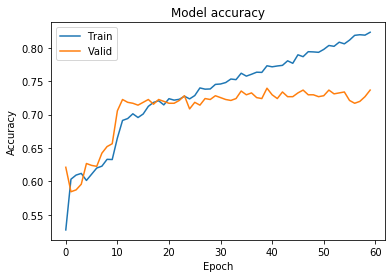

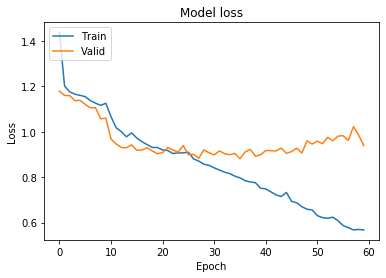

In [167]:
def history_plot(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper left')
    plt.show()
    
history_plot(history)

In [23]:
model = load_model('models/model1_weights.hdf5')
model.evaluate([x_valid_pad, valid_helix_pad, valid_signalP_pad], y_valid_OH, verbose=0)

[0.8806319401297771, 0.7295774817466736]

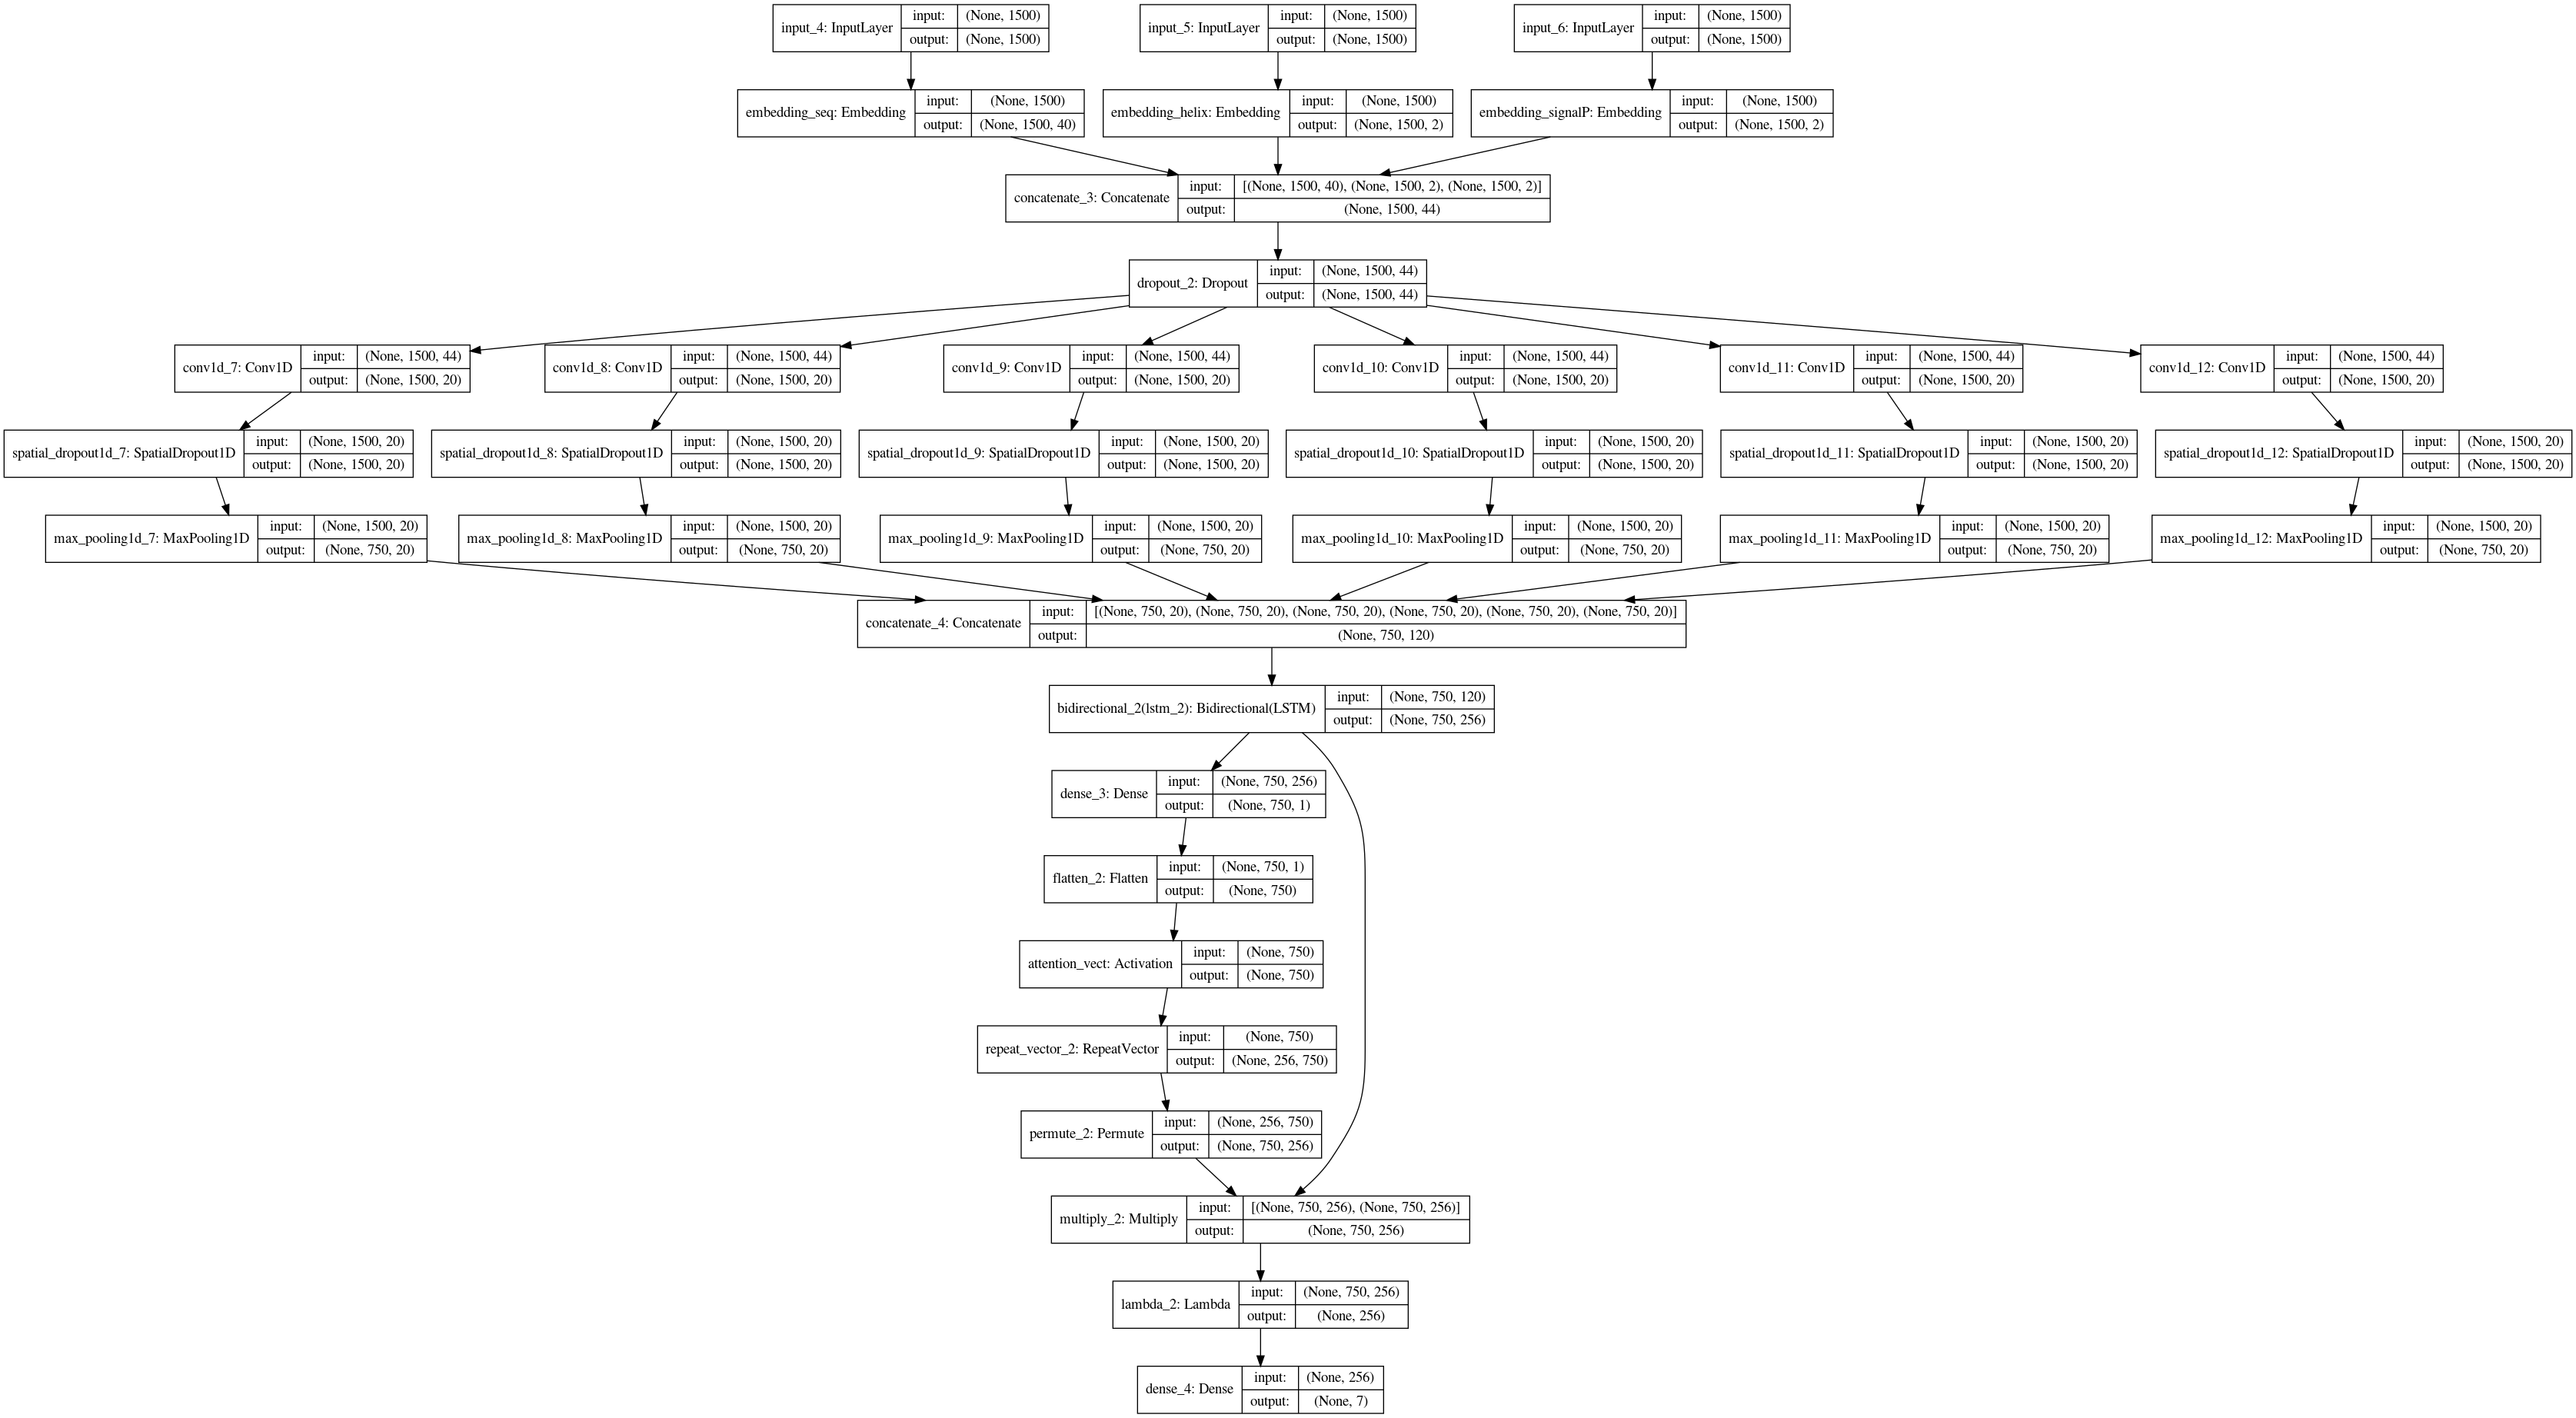

In [95]:
plot_model(model, to_file='models/model1_plot.png', show_shapes=True, show_layer_names=True)

In [24]:
y_pred = model.predict([x_valid_pad, valid_helix_pad, valid_signalP_pad])
y_pred_indices = OH_to_label_indices(y_pred)
y_pred_label = indices_to_cat(y_pred_indices)

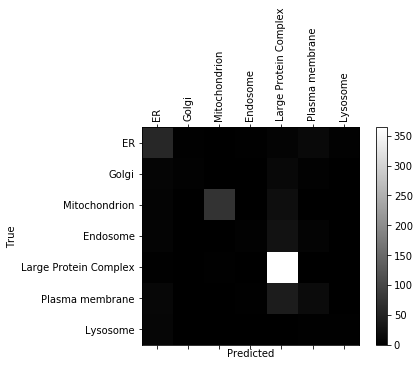

In [25]:
def confusion_plot(y_valid, y_pred_label, cat):
    conf_mx = confusion_matrix(y_valid, y_pred_label, labels=cat)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mx, cmap=plt.cm.gray)
    fig.colorbar(cax)
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.set_xticklabels([''] + cat,  rotation='vertical')
    ax.set_yticklabels([''] + cat)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
confusion_plot(y_valid, y_pred_label, cat)

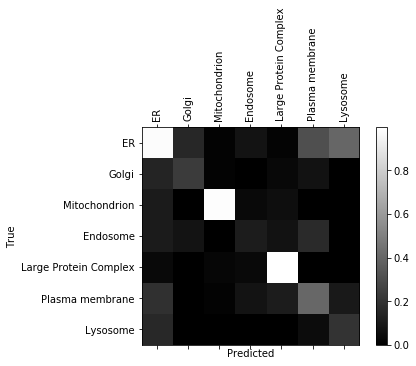

In [26]:
def confusion_plot_norm(y_valid, y_pred_label, cat, axis=1):
    conf_mx = confusion_matrix(y_valid, y_pred_label, labels=cat)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mx / (conf_mx.max(axis=axis)+1), cmap=plt.cm.gray)
    fig.colorbar(cax)
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.set_xticklabels([''] + cat,  rotation='vertical')
    ax.set_yticklabels([''] + cat)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    return(conf_mx)
conf = confusion_plot_norm(y_valid, y_pred_label, cat, axis=1)

In [27]:
conf

array([[ 56,   2,   1,   2,   7,  13,   4],
       [  8,   3,   1,   0,  12,   3,   0],
       [  6,   0,  73,   1,  20,   0,   0],
       [  6,   1,   0,   3,  26,   7,   0],
       [  2,   0,   2,   1, 364,   0,   0],
       [ 11,   0,   1,   2,  41,  17,   1],
       [  9,   0,   0,   0,   0,   2,   2]])

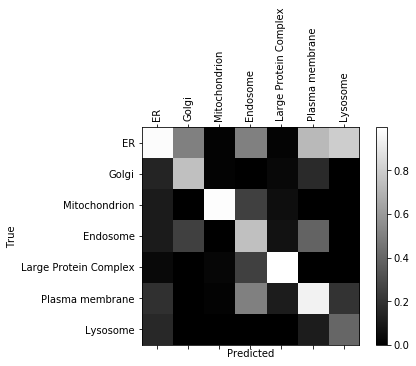

array([[ 56,   2,   1,   2,   7,  13,   4],
       [  8,   3,   1,   0,  12,   3,   0],
       [  6,   0,  73,   1,  20,   0,   0],
       [  6,   1,   0,   3,  26,   7,   0],
       [  2,   0,   2,   1, 364,   0,   0],
       [ 11,   0,   1,   2,  41,  17,   1],
       [  9,   0,   0,   0,   0,   2,   2]])

In [28]:
confusion_plot_norm(y_valid, y_pred_label, cat, axis=0)

In [101]:
print(classification_report(y_valid, y_pred_label))

                       precision    recall  f1-score   support

                   ER       0.57      0.66      0.61        85
             Endosome       0.33      0.07      0.12        43
                Golgi       0.50      0.11      0.18        27
Large Protein Complex       0.77      0.99      0.87       369
             Lysosome       0.29      0.15      0.20        13
        Mitochondrion       0.94      0.73      0.82       100
      Plasma membrane       0.40      0.23      0.30        73

             accuracy                           0.73       710
            macro avg       0.54      0.42      0.44       710
         weighted avg       0.69      0.73      0.69       710



## Embedding Analysis

In [103]:
embedding = model.get_layer('embedding_seq').get_weights()
embedding = embedding[0]
embedding.shape

(22, 40)

In [108]:
colors = ['k','tab:orange','b', 'm', 'r', 'g', 'm', 'r', 'tab:orange', 'm', 'g', 'g', 'b', 'g', 'g', 'g',
          'tab:orange', 'tab:orange', 'g', 'g', 'g', 'k']

def plot_embedding(embedding, aa, colors):
    fig, ax = plt.subplots()
    plt.scatter(embedding[:, 0], embedding[:, 1], edgecolor='none', c=colors)
    aaL = list(aa)
    for i in range(len(aaL)):
        ax.annotate(aaL[i], (embedding[:, 0][i], embedding[:, 1][i]))
    
    plt.show()

### PCA plot

original shape:    (22, 40)
transformed shape: (22, 2)


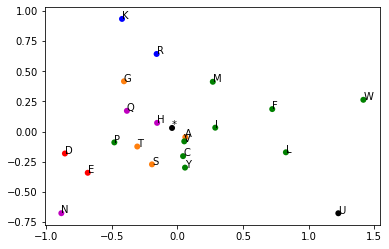

In [110]:
# PCA plots of Embedding 
pca = PCA(n_components=2)
pca.fit(embedding)
embedding_pca = pca.transform(embedding)
print("original shape:   ", embedding.shape)
print("transformed shape:", embedding_pca.shape)
plot_embedding(embedding_pca, aa, colors)

### t-SNE plot

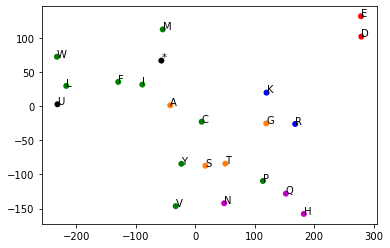

In [111]:
# tSNE plots of Embedding 
tSNE = TSNE(n_components=2, perplexity=3)
embedding_tSNE = tSNE.fit_transform(embedding)
plot_embedding(embedding_tSNE, aa, colors)

### UMAP plot

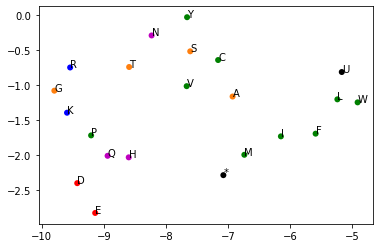

In [112]:
# umap plots of Embedding 
Umap = umap.UMAP(n_components=2, n_neighbors= 4)
embedding_Umap = Umap.fit_transform(embedding)
plot_embedding(embedding_Umap, aa, colors)

## Attention Layer Analysis

In [126]:
model = load_model('models/model1_weights.hdf5')
model = Model(inputs=model.input,
              outputs=[model.output, model.get_layer('attention_vect').output])
outputs = model.predict([x_valid_pad, valid_helix_pad, valid_signalP_pad])
model_outputs = outputs[0]
attention_outputs = outputs[1]

/home/julie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


Text(0, 0.5, 'Attention Distribution')

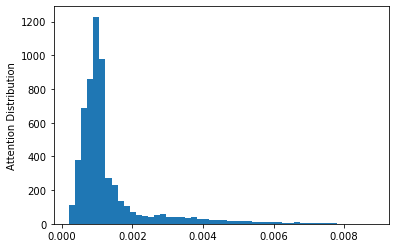

In [127]:
attention_distrib = np.concatenate( attention_outputs, axis=0 )
plt.hist(attention_distrib, normed=True, bins=50)
plt.ylabel('Attention Distribution')

/home/julie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


Text(0, 0.5, 'Attention Distribution')

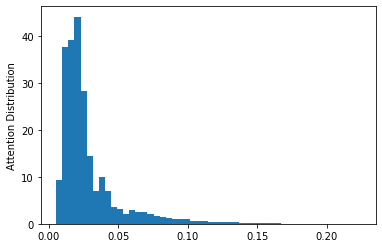

In [128]:
# Normalize attention values 
norm_attention = []
for seq in attention_outputs:
    norm_attention.append(seq / np.linalg.norm(seq))
    
attention_distrib = np.concatenate( norm_attention, axis=0 )
plt.hist(attention_distrib, normed=True, bins=50)
plt.ylabel('Attention Distribution')

### Attention visualization for a single sequence

Because I pooled (pool size = 2) attention is len = 750. 
So I need to duplicate every values.

In [129]:
def indices_to_seq(X):
    seq = ''
    for i in range(len(X)):
        seq +=int_to_aa[X[i]] 
    return seq

In [130]:
# pool_size = 2
Attention_1500 = []
A = []
for x in norm_attention:
    for i in range(len(x)):
        A.append(x[i])
        A.append(x[i])
    Attention_1500.append(np.array(A))
    A = []

In [131]:
# I don't fully understand that code
# the color_charvals function doesn't work that well because my vector is big
# and the values are very small, I need a better function

class CharVal(object):
    def __init__(self, char, val):
        self.char = char
        self.val = val

    def __str__(self):
        return self.char

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

def color_charvals(s):
    r = 0
    if s.val < 0.07:
        r = 255
    elif s.val > 0.1:
        r = 0
    else:
        r = 255*(1 - (s.val-0.07)/0.03)
    r = int(r)
    color = rgb_to_hex((255, r, 255))
    return 'background-color: %s' % color
    
    #r = int(255/(s.val*10 +1))
    #color = rgb_to_hex((r, r, r))
    #return 'background-color: %s' % color

In [132]:
# Number of highest values to select
nb_max = 30
max_att_indexes = []
for seq in Attention_1500:
    max_att_indexes.append(np.sort(np.argpartition(seq, -nb_max)[-nb_max:]))
max_att_nopad = []    
for x in range(len(x_valid)):
    max_att_nopad.append(max_att_indexes[x]-(1500-len(x_valid[x])))

In [133]:
X = 3

def color_charvals(s):
    r = 255-int(s.val*255)
    color = rgb_to_hex((255,255 , r))
    return 'background-color: %s' % color

max_ind = max_att_nopad[X]
max_vect = np.zeros(len(x_valid[X]))
for val in max_ind:
    max_vect[val] = 1
# match each aa and attention
char_vals = [CharVal(c, v) for c, v in 
             zip(x_valid[X], max_vect)]

char_df = pd.DataFrame(char_vals).transpose()
# apply coloring values
char_df = char_df.style.applymap(color_charvals)
char_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326
0,M,A,A,A,A,A,A,A,A,A,T,N,G,T,G,G,S,S,G,M,E,V,D,A,A,V,V,P,S,V,M,A,C,G,V,T,G,S,V,S,V,A,L,H,P,L,V,I,L,N,I,S,D,H,W,I,R,M,R,S,Q,E,G,R,P,V,Q,V,I,G,A,L,I,G,K,Q,E,G,R,N,I,E,V,M,N,S,F,E,L,L,S,H,T,V,E,E,K,I,I,I,D,K,E,Y,Y,Y,T,K,E,E,Q,F,K,Q,V,F,K,E,L,E,F,L,G,W,Y,T,T,G,G,P,P,D,P,S,D,I,H,V,H,K,Q,V,C,E,I,I,E,S,P,L,F,L,K,L,N,P,M,T,K,H,T,D,L,P,V,S,V,F,E,S,V,I,D,I,I,N,G,E,A,T,M,L,F,A,E,L,T,Y,T,L,A,T,E,E,A,E,R,I,G,V,D,H,V,A,R,M,T,A,T,G,S,G,E,N,S,T,V,A,E,H,L,I,A,Q,H,S,A,I,K,M,L,H,S,R,V,K,L,I,L,E,Y,V,K,A,S,E,A,G,E,V,P,F,N,H,E,I,L,R,E,A,Y,A,L,C,H,C,L,P,V,L,S,T,D,K,F,K,T,D,F,Y,D,Q,C,N,D,V,G,L,M,A,Y,L,G,T,I,T,K,T,C,N,T,M,N,Q,F,V,N,K,F,N,V,L,Y,D,R,Q,G,I,G,R,R,M,R,G,L,F,F


## Error Analysis

In [142]:
# Make simplified Valid dataset for error Analysis
Val =  valid.drop(['Sequence', 'Topology Seq','Signal Peptide Seq'], 1)

In [143]:
Val.head()

,Lead Protein ID,Compartment Prediction,Prediction Confidence,Sequence Lengh,ExpAA,First60,PredHel,Topology,Prediction,SP(Sec/SPI),CS Position
0,P35269,Large Protein Complex,Very High,517,0.00,0.00,0,[],OTHER,0.000495,[]
1,O75694,Plasma membrane,Medium,1391,0.06,0.00,0,[],OTHER,0.012633,[]
2,P53365,Golgi,Medium,341,0.05,0.00,0,[],OTHER,0.002517,[]
3,Q7L5N1,Large Protein Complex,Very High,327,6.15,6.11,0,[],OTHER,0.003544,[]
4,P54278,Large Protein Complex,Very High,862,0.07,0.00,0,[],OTHER,0.000913,[]


In [144]:
# Add the prediction to Valid dataframe
Val["Model Prediction"] = y_pred_label

In [145]:
Val.groupby(["Compartment Prediction", "Model Prediction"]).count()#/len(valid)*100

Lead Protein ID  \
Compartment Prediction Model Prediction                         
ER                     ER                                  56   
                       Endosome                             2   
                       Golgi                                2   
                       Large Protein Complex                7   
                       Lysosome                             4   
                       Mitochondrion                        1   
                       Plasma membrane                     13   
Endosome               ER                                   6   
                       Endosome                             3   
                       Golgi                                1   
                       Large Protein Complex               26   
                       Plasma membrane                      7   
Golgi                  ER                                   8   
                       Golgi                                3   
                       Large Protein Complex               12   
                       Mitochondrion                        1   
                       Plasma membrane                      3   
Large Protein Complex  ER                                   2   
                       Endosome                             1   
                       Large Protein Complex              364   
                       Mitochondrion                        2   
Lysosome               ER                                   9   
                       Lysosome                             2   
                       Plasma membrane                      2   
Mitochondrion          ER                                   6   
                       Endosome                             1   
                       Large Protein Complex               20   
                       Mitochondrion                       73   
Plasma membrane        ER                                  11   
                       Endosome                             2   
                       Large Protein Complex               41   
                       Lysosome                             1   
                       Mitochondrion                        1   
                       Plasma membrane                     17   

                                              Prediction Confidence  \
Compartment Prediction Model Prediction                               
ER                     ER                                        56   
                       Endosome                                   2   
                       Golgi                                      2   
                       Large Protein Complex                      7   
                       Lysosome                                   4   
                       Mitochondrion                              1   
                       Plasma membrane                           13   
Endosome               ER                                         6   
                       Endosome                                   3   
                       Golgi                                      1   
                       Large Protein Complex                     26   
                       Plasma membrane                            7   
Golgi                  ER                                         8   
                       Golgi                                      3   
                       Large Protein Complex                     12   
                       Mitochondrion                              1   
                       Plasma membrane                            3   
Large Protein Complex  ER                                         2   
                       Endosome                                   1   
                       Large Protein Complex                    364   
                       Mitochondrion                              2   
Lysosome               ER                                         9   
 

In [146]:
# THIS CODE OUTPUT THE INDICES FOR CORRECT AND INCORRECT EXEMPLES.
corrects = []
falses = []
for x in range(len(y_valid)):
    if y_valid_indices[x] == y_pred_indices[x]:
        corrects.append(x)
    else:
        falses.append(x)

In [147]:
print('There is ' + str(len(corrects)) + ' correctly classified exemples')
print('There is ' + str(len(falses)) + ' incorrectly classified exemples')
print('So the accuracy is: ' + str(len(corrects)/len(x_valid)*100))

There is 518 correctly classified exemples
There is 192 incorrectly classified exemples
So the accuracy is: 72.95774647887325


In [148]:
corrects_df = Val[Val.index.isin(corrects)]
corrects_df.head()

,Lead Protein ID,Compartment Prediction,Prediction Confidence,Sequence Lengh,ExpAA,First60,PredHel,Topology,Prediction,SP(Sec/SPI),CS Position,Model Prediction
0,P35269,Large Protein Complex,Very High,517,0.00,0.00,0,[],OTHER,0.000495,[],Large Protein Complex
3,Q7L5N1,Large Protein Complex,Very High,327,6.15,6.11,0,[],OTHER,0.003544,[],Large Protein Complex
4,P54278,Large Protein Complex,Very High,862,0.07,0.00,0,[],OTHER,0.000913,[],Large Protein Complex
5,Q9NWU5,Mitochondrion,High,206,0.01,0.00,0,[],OTHER,0.007467,[],Mitochondrion
6,O00571,Large Protein Complex,High,662,0.00,0.00,0,[],OTHER,0.001468,[],Large Protein Complex


In [149]:
# Now I use these list of indices to split the valid pandas dataframe
falses_df = Val[Val.index.isin(falses)]
falses_df.head()

,Lead Protein ID,Compartment Prediction,Prediction Confidence,Sequence Lengh,ExpAA,First60,PredHel,Topology,Prediction,SP(Sec/SPI),CS Position,Model Prediction
1,O75694,Plasma membrane,Medium,1391,0.06,0.00,0,[],OTHER,0.012633,[],Large Protein Complex
2,P53365,Golgi,Medium,341,0.05,0.00,0,[],OTHER,0.002517,[],Large Protein Complex
12,Q15311,Plasma membrane,Low,655,0.00,0.00,0,[],OTHER,0.000878,[],Large Protein Complex
18,Q8TC12,ER,Very High,318,12.33,12.29,0,[],SP(Sec/SPI),0.765850,['20-21'],Lysosome
23,Q86XL3,ER,Very High,938,17.36,17.36,1,['13-32'],OTHER,0.005387,[],Golgi


### Checking how low/very low Prediction Confidence proteins are classified

And to a certain extend, low confidence proteins are more often wrongly classified.
It make sense but it is not as bad as I was expecting.

It could make sense to remove these exemples from the dataset altogether. 

In [150]:
falses_df["Prediction Confidence"].value_counts()/ len(falses_df)*100

Very High    27.604167
High         23.958333
Medium       21.875000
Low          18.229167
Very Low      8.333333
Name: Prediction Confidence, dtype: float64

In [151]:
corrects_df["Prediction Confidence"].value_counts()/ len(corrects_df)*100

Very High    40.347490
High         26.833977
Medium       17.374517
Very Low      8.687259
Low           6.756757
Name: Prediction Confidence, dtype: float64

## Checking model on test set 

In [154]:
test = pd.read_csv("data/7C_test.csv", sep="\t")
y_test = test["Compartment Prediction"]
y_test_indices = cat_to_indices(y_test)
y_test_OH = convert_to_one_hot(y_test_indices, C = tot_cat)

x_test = test["Sequence"].copy()
x_test_indices = seq_to_indices(x_test, aa_to_int, max_len)
x_test_pad = sequence.pad_sequences(x_test_indices, maxlen=max_len, value=aa_to_int["*"])

test_helix = test["Topology Seq"]
test_signalP = test["Signal Peptide Seq"]

test_helix = convert_to_list(test_helix)
test_signalP = convert_to_list(test_signalP)

test_helix_pad = sequence.pad_sequences(test_helix, maxlen=max_len, value=0)
test_signalP_pad = sequence.pad_sequences(test_signalP, maxlen=max_len, value=0)

In [155]:
model = load_model('models/model1_weights.hdf5')
score = model.evaluate([x_test_pad, test_helix_pad, test_signalP_pad], y_test_OH)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

696/696 [==============================] - 21s 30ms/step
Test loss: 0.9271920528905145
Test accuracy: 0.7313218116760254


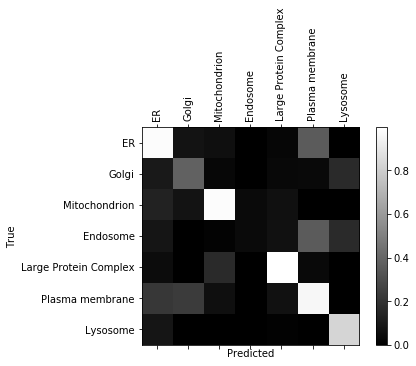

In [157]:
y_pred_test = model.predict([x_test_pad, test_helix_pad, test_signalP_pad])
y_pred_indices_test = OH_to_label_indices(y_pred_test)
y_pred_label_test = indices_to_cat(y_pred_indices_test)

conf_mx = confusion_matrix(y_test, y_pred_label_test, labels=cat)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mx / (conf_mx.max(axis=1)+1), cmap=plt.cm.gray)
fig.colorbar(cax)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_xticklabels([''] + cat,  rotation='vertical')
ax.set_yticklabels([''] + cat)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [158]:
conf_mx

array([[ 59,   1,   4,   0,   9,  10,   0],
       [  6,   5,   2,   0,  12,   1,   1],
       [  8,   1,  65,   1,  23,   0,   0],
       [  5,   0,   1,   1,  24,  10,   1],
       [  3,   0,  11,   0, 347,   1,   0],
       [ 13,   3,   4,   0,  24,  27,   0],
       [  5,   0,   0,   0,   3,   0,   5]])

## 2nd Model

Embedding for feature prediction need to be at least 2! (number of feature)

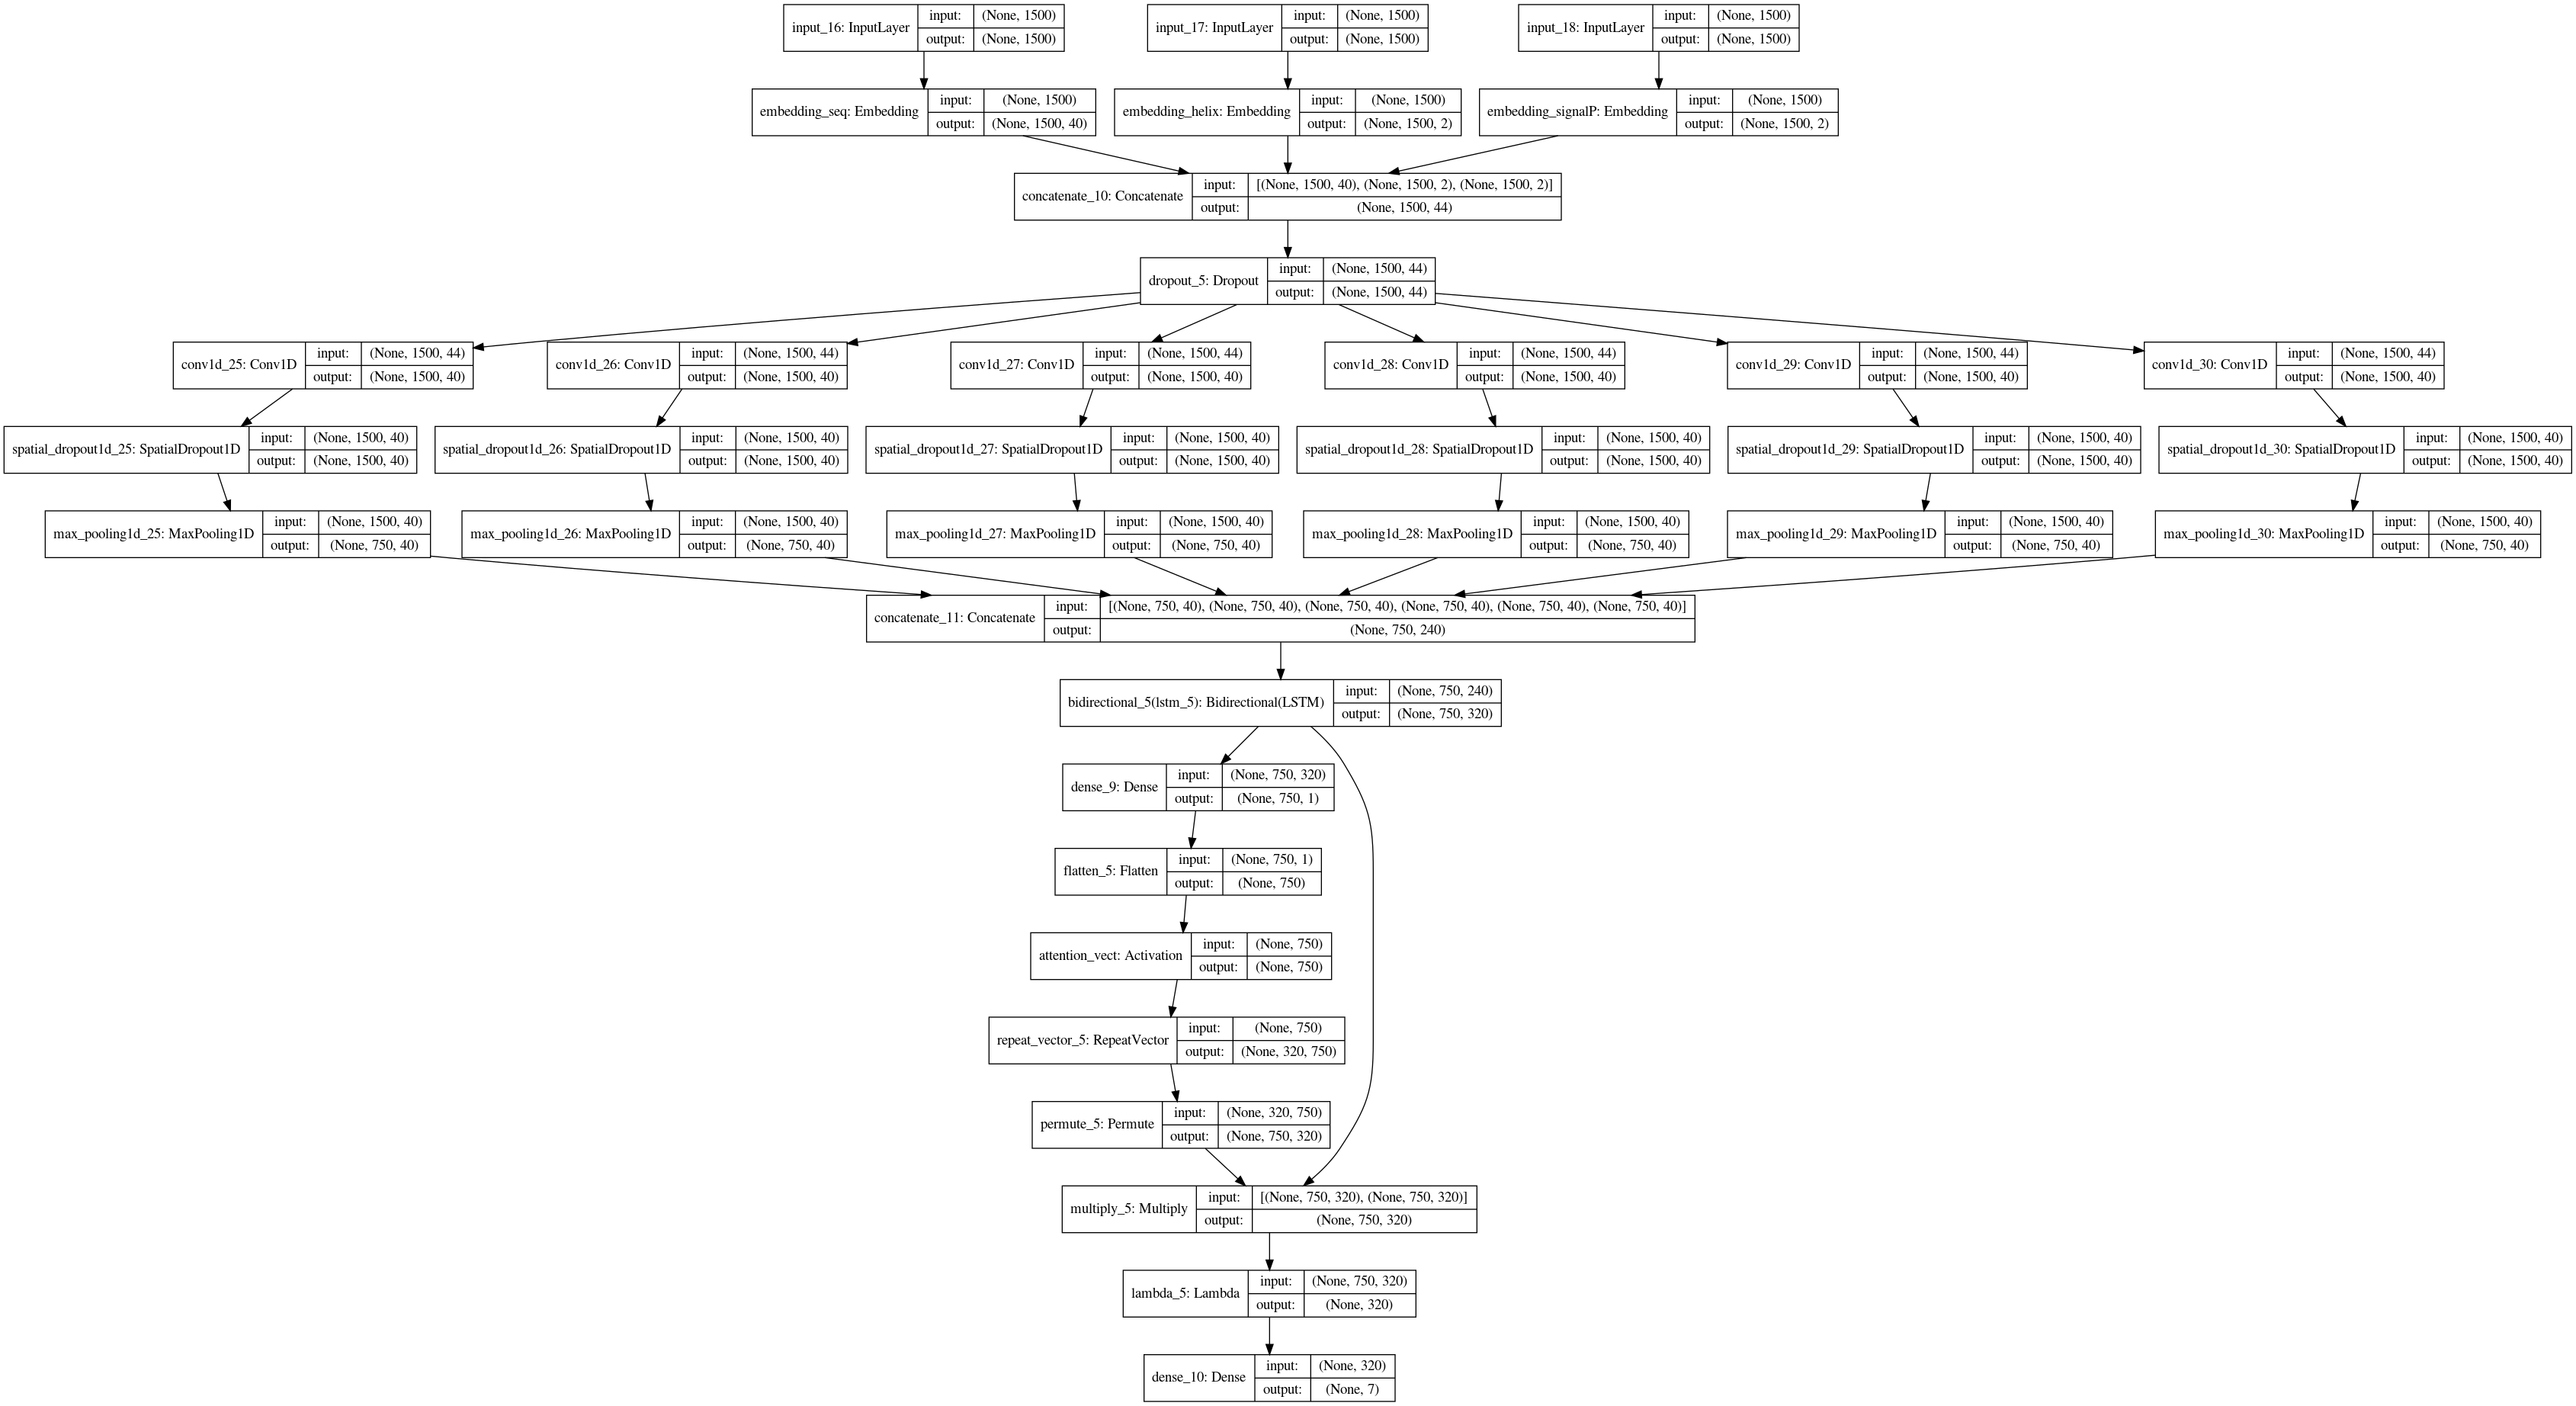

In [164]:
max_aa = tot_aa
max_feature = 2
batch_size = 32

#LSTM
units = 160
# Embedding
embedding_size = 40
feature_embedding_size = 2

# Convolution
filters = 40
pool_size = 2

input_seq = Input(shape=[max_len], dtype='int32')
input_helix = Input(shape=[max_len], dtype='int32')
input_signalP = Input(shape=[max_len], dtype='int32')

# get the embedding layer
embedded_seq = Embedding(input_dim=max_aa,output_dim=embedding_size,
        input_length=max_len, name = 'embedding_seq', trainable=True, mask_zero=False)(input_seq)

embedded_helix = Embedding(input_dim=max_feature,output_dim=feature_embedding_size,
        input_length=max_len, name = 'embedding_helix', trainable=True, mask_zero=False)(input_helix)

embedded_signalP = Embedding(input_dim=max_feature,output_dim=feature_embedding_size,
        input_length=max_len, name = 'embedding_signalP', trainable=True, mask_zero=False)(input_signalP)

concat_input = concatenate([embedded_seq, embedded_helix, embedded_signalP], axis=2)

drop = Dropout(0.2)(concat_input)
# Convolution layer of different size

conv2 = Conv1D(filters, 2, padding='same', activation='relu', 
              strides=1)(drop)
drop2 = SpatialDropout1D(0.2)(conv2)
pool2 = MaxPooling1D(pool_size=pool_size)(drop2)

conv3 = Conv1D(filters, 3, padding='same', activation='relu', 
              strides=1)(drop)
drop3 = SpatialDropout1D(0.2)(conv3)
pool3 = MaxPooling1D(pool_size=pool_size)(drop3)

conv5 = Conv1D(filters, 5, padding='same', activation='relu', 
              strides=1)(drop)
drop5 = SpatialDropout1D(0.2)(conv5)
pool5 = MaxPooling1D(pool_size=pool_size)(drop5)

conv9 = Conv1D(filters, 9, padding='same', activation='relu', 
              strides=1)(drop)
drop9 = SpatialDropout1D(0.2)(conv9)
pool9 = MaxPooling1D(pool_size=pool_size)(drop9)

conv12 = Conv1D(filters, 12, padding='same', activation='relu', 
              strides=1)(drop)
drop12 = SpatialDropout1D(0.2)(conv12)
pool12 = MaxPooling1D(pool_size=pool_size)(drop12)

conv16 = Conv1D(filters, 16, padding='same', activation='relu', 
              strides=1)(drop)
drop16 = SpatialDropout1D(0.2)(conv16)
pool16 = MaxPooling1D(pool_size=pool_size)(drop16)

# Concatenate the filters
#concat = concatenate([drop2, drop3, drop5, drop9, drop12], axis=2)
concat = concatenate([pool2, pool3, pool5, pool9, pool12, pool16], axis=2)

#pool = MaxPooling1D(pool_size=pool_size)(concat)

activations = Bidirectional(LSTM(units, return_sequences=True, 
                                 dropout=0.2, recurrent_dropout=0.2))(concat)

# compute importance for each step
attention = Dense(1, activation='tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax', name = 'attention_vect')(attention) # attention_vect for visualization
attention = RepeatVector(units*2)(attention)
attention = Permute([2, 1])(attention)
sent_representation = Multiply()([activations, attention])
sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(units*2,))(sent_representation)

probabilities = Dense(7, activation='softmax')(sent_representation)

model2 = Model(inputs=[input_seq, input_helix, input_signalP], outputs=probabilities)
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
d_class_weights = dict(enumerate(class_weights))

model2.compile('Nadam', 'categorical_crossentropy', metrics=['accuracy'])
plot_model(model2, to_file='models/model2_plot.png', show_shapes=True, show_layer_names=True)

In [165]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
d_class_weights = dict(enumerate(class_weights))

model2.compile('Nadam', 'categorical_crossentropy', metrics=['accuracy'])
ckpt = ModelCheckpoint(filepath='models/model2_weights.hdf5', 
                           verbose=1, save_best_only=True)
# Train, train, train
history2 = model2.fit([x_train_pad, train_helix_pad, train_signalP_pad], y_train_OH, 
                    batch_size=32, epochs=60,
                    class_weight = class_weights,
          validation_data=[[x_valid_pad, valid_helix_pad, valid_signalP_pad], y_valid_OH], callbacks=[ckpt])

Train on 3229 samples, validate on 710 samples
Epoch 1/60
3229/3229 [==============================] - 490s 152ms/step - loss: 1.4099 - accuracy: 0.5348 - val_loss: 1.2006 - val_accuracy: 0.5718

Epoch 00001: val_loss improved from inf to 1.20064, saving model to models/model2_weights.hdf5
Epoch 2/60
3229/3229 [==============================] - 486s 150ms/step - loss: 1.1958 - accuracy: 0.5971 - val_loss: 1.1680 - val_accuracy: 0.6211

Epoch 00002: val_loss improved from 1.20064 to 1.16801, saving model to models/model2_weights.hdf5
Epoch 3/60
3229/3229 [==============================] - 405s 125ms/step - loss: 1.1819 - accuracy: 0.6048 - val_loss: 1.1607 - val_accuracy: 0.5676

Epoch 00003: val_loss improved from 1.16801 to 1.16065, saving model to models/model2_weights.hdf5
Epoch 4/60
3229/3229 [==============================] - 398s 123ms/step - loss: 1.1630 - accuracy: 0.6024 - val_loss: 1.1261 - val_accuracy: 0.6268

Epoch 00004: val_loss improved from 1.16065 to 1.12607, saving m

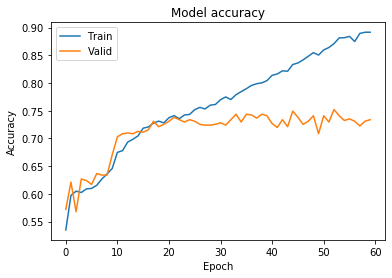

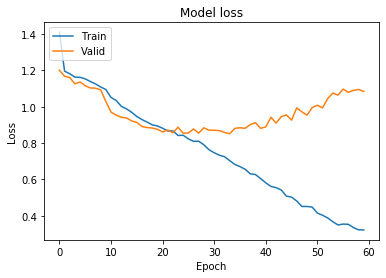

In [168]:
history_plot(history2)

In [19]:
model2 = load_model('models/model2_weights.hdf5')
model2.evaluate([x_valid_pad, valid_helix_pad, valid_signalP_pad], y_valid_OH, verbose=0)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


[0.8515417632922321, 0.7436619997024536]

In [20]:
y_pred2 = model2.predict([x_valid_pad, valid_helix_pad, valid_signalP_pad])
y_pred_indices2 = OH_to_label_indices(y_pred2)
y_pred_label2 = indices_to_cat(y_pred_indices2)

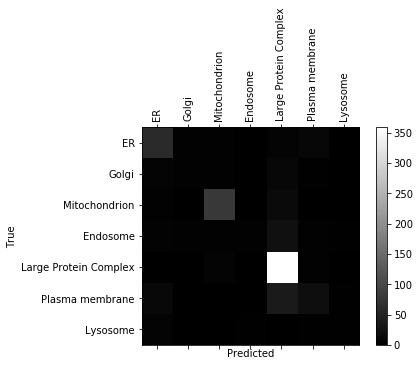

In [29]:
confusion_plot(y_valid, y_pred_label2, cat)

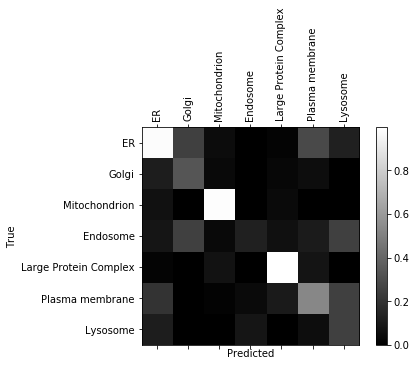

array([[ 59,   3,   4,   0,   7,  11,   1],
       [  7,   4,   3,   0,  11,   2,   0],
       [  4,   0,  81,   0,  15,   0,   0],
       [  5,   3,   3,   3,  23,   4,   2],
       [  1,   0,   6,   0, 359,   3,   0],
       [ 12,   0,   1,   1,  37,  20,   2],
       [  7,   0,   0,   2,   0,   2,   2]])

In [30]:
confusion_plot_norm(y_valid, y_pred_label2, cat, axis=1)

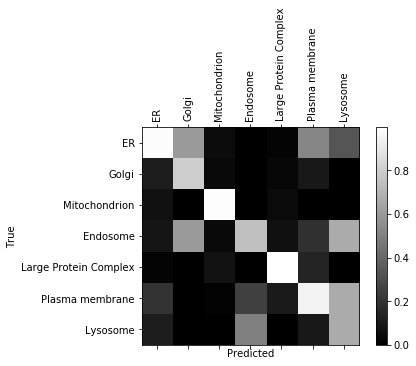

array([[ 59,   3,   4,   0,   7,  11,   1],
       [  7,   4,   3,   0,  11,   2,   0],
       [  4,   0,  81,   0,  15,   0,   0],
       [  5,   3,   3,   3,  23,   4,   2],
       [  1,   0,   6,   0, 359,   3,   0],
       [ 12,   0,   1,   1,  37,  20,   2],
       [  7,   0,   0,   2,   0,   2,   2]])

In [31]:
confusion_plot_norm(y_valid, y_pred_label2, cat, axis=0)

In [32]:
print(classification_report(y_valid, y_pred_label2))

                       precision    recall  f1-score   support

                   ER       0.62      0.69      0.66        85
             Endosome       0.50      0.07      0.12        43
                Golgi       0.40      0.15      0.22        27
Large Protein Complex       0.79      0.97      0.87       369
             Lysosome       0.29      0.15      0.20        13
        Mitochondrion       0.83      0.81      0.82       100
      Plasma membrane       0.48      0.27      0.35        73

             accuracy                           0.74       710
            macro avg       0.56      0.45      0.46       710
         weighted avg       0.70      0.74      0.70       710

